# Classify NEON AOP Aspect Raster into North and South Facing Slopes

Nicole Abib   
nicole.abib@duke.edu

The goal of this project is to classify a NEON AOP raster for the Teakettle Watershed into North and South facing slopes where North is 0-45 & 315-360 degrees and South is 135 - 225 degrees.

In [1]:
# Check python version
import sys
sys.version

'3.5.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:11:22) \n[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]'

In [2]:
# Import required libraries
import numpy as np
import gdal, copy
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
# %load ../functions/neon_aop_lidar_python_functions/raster2array.py
def raster2array(geotif_file):
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()
    
    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    xMin = mapinfo[0]
    xMax = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    yMin = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    yMax = mapinfo[3]
    
    metadata['extent'] = (xMin,xMax,yMin,yMax)
    
    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()
    
    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix
    
    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()
              
        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(np.float)
        array[np.where(array==metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']
    
    elif metadata['bands'] > 1:    
        for i in range(1, dataset.RasterCount+1):
            band = float(dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']))
            band[np.where(band==metadata['noDataValue'])]=np.nan
            band = band/metadata['scaleFactor']
            array[...,i-1] = band

    return array, metadata

In [4]:
teak_tile, teak_metadata = raster2array('../data/Day2_LiDAR_Intro/NEON_D17_TEAK_DP3_316000_4106000_aspect.tif')

In [54]:
teak_aspect_reclass = copy.copy(teak_tile)
teak_aspect_reclass[np.where((teak_tile >= 0) & (teak_tile <= 45) 
                             | (teak_tile >= 315))] = 1 
teak_aspect_reclass[np.where((teak_tile > 135) & 
                             (teak_tile <= 225))] = 2 
teak_aspect_reclass[np.where((teak_tile > 45) 
                             & (teak_tile <= 135))] = np.nan 
teak_aspect_reclass[np.where((teak_tile > 225) 
                             & (teak_tile <= 315))] = np.nan 
teak_aspect_reclass

array([[nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       [nan, nan, nan, ...,  1.,  1.,  1.],
       ...,
       [ 2.,  2.,  2., ...,  2.,  2., nan],
       [ 2.,  2.,  2., ...,  2.,  2., nan],
       [ 2.,  2.,  2., ...,  2.,  2., nan]])

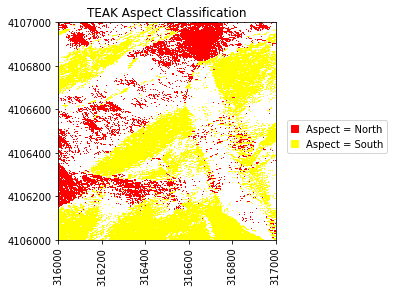

In [56]:
# Plot classified canopy height model
import matplotlib.colors as colors
plt.figure()
cmapAspect = colors.ListedColormap(['red','yellow'])
plt.imshow(teak_aspect_reclass,
           extent=teak_metadata['extent'],
           cmap=cmapAspect)
plt.title('TEAK Aspect Classification')
ax = plt.gca()
ax.ticklabel_format(useOffset=False, 
                    style='plain')
rotatexlabels = plt.setp(ax.get_xticklabels(),
                         rotation=90)

import matplotlib.patches as mpatches
class1_box = mpatches.Patch(color='red', label='Aspect = North')
class2_box = mpatches.Patch(color='yellow', label='Aspect = South')

ax.legend(handles = [class1_box,class2_box], 
                     handlelength = 0.7, 
                     bbox_to_anchor = (1.05, 0.4),
                     loc='lower left',borderaxespad=0.)